# Imaging observations of HL Tau

The purpose of this notebook is to show how to use an image to create a `Source` object for imaging observations with METIS. We work with an ALMA 233 GHz image of HL Tau, pretending that this is the structure of the object in the mid-infrared. It will be joined to a very simple spectrum. The notebook demonstrates how to scale the image in terms of flux to make a plausible source for MIR observations.

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from synphot import SourceSpectrum
from synphot.models import Empirical1D

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import scopesim as sim

In [4]:
sim.bug_report()

Python:
 3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]

scopesim :  0.1.0
numpy :  1.20.3
scipy :  1.6.3
astropy :  4.2.1
matplotlib :  3.4.2
synphot :  1.0.1
requests :  2.25.1
bs4 :  4.9.3
yaml :  5.3.1

Operating system:  Linux
         Release:  5.10.0-6-amd64
         Version:  #1 SMP Debian 5.10.28-1 (2021-04-09)
         Machine:  x86_64


The following is needed to access my development repository for irdb/METIS. This should be replaced by the downloaded package once that is available.

In [5]:
PKGS_DIR = os.path.abspath(
    os.path.join(
        os.path.dirname("/home/oczoske/ELT_Development/irdb/METIS")))
sim.rc.__config__["!SIM.file.local_packages_path"] = PKGS_DIR

## Creating a source object from an image and a spectrum

The image that we use is `HLTau_B6cont_mscale_ap.image.fits`, which has been retrieved from the ESO Science archive. The data section is a four-dimensional cube, where the third and fourth dimensions have only one layer each and can be ignored. 

In [6]:
hdul = fits.open("HLTau_B6cont_mscale_ap.image.fits")

The next line extracts the image and drops the superfluous dimensions:

In [7]:
img_data = hdul[0].data[0,0,:,:]

In [8]:
img_data.shape

(1600, 1600)

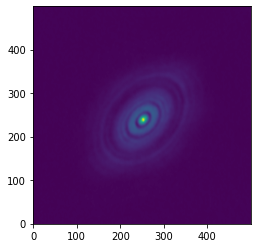

In [9]:
plt.imshow(img_data[600:1100,550:1050], origin='lower')

The WCS of the image is needed mostly for the pixel scales - of course we could set these by hand and pretend that the object is smaller or larger than in the original, but we'll stick with the latter. `.sub(2)` extracts the relevant dimensions from the 4-dimensional WCS. We then set `CRVAL` to 0. because the pointing capabilities of ScopeSim are somewhat limited.

In [10]:
wcs = WCS(hdul[0].header).sub(2)

In [11]:
wcs.wcs.crval = [0., 0.]

A `Source` object in ScopeSim consists of an image (given as a FITS `HDU`) and a spectrum. The spectrum carries absolute flux units, e.g. Jy. A pixel value of 1 in the image assigns to that pixel just that flux density, other values scale the fluxes accordingly. In the example of HL Tau, we choose to scale the source such that the average surface flux density is $0.1 \mathrm{Jy\,arcsec^{-2}}$ at $10\,\mu$m. We will later set up the spectrum such that this is the case. For the image, we need to ensure that the average pixel value over the first ring is 1. This was done using ds9 with an elliptical aperture region as shown in the screenshots.

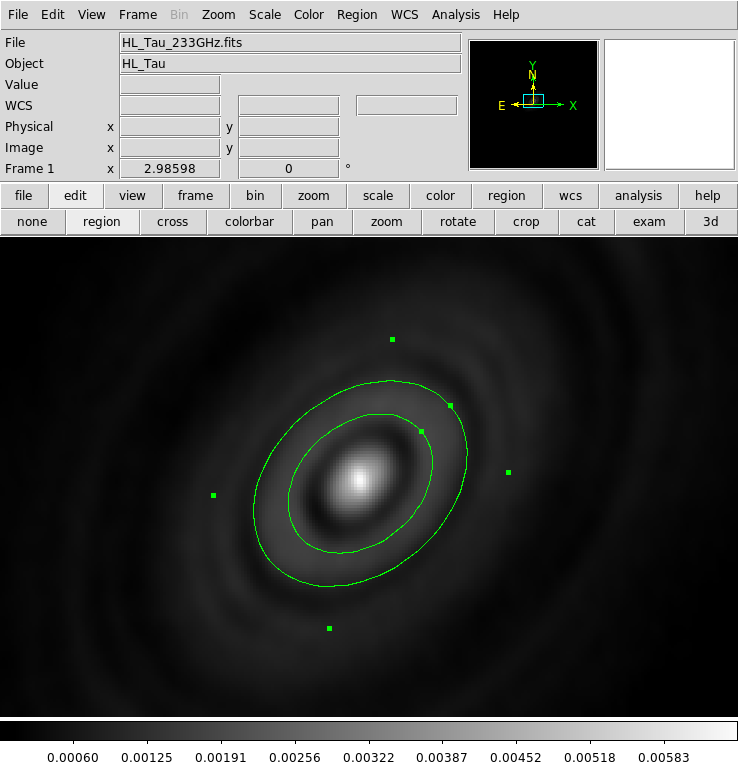

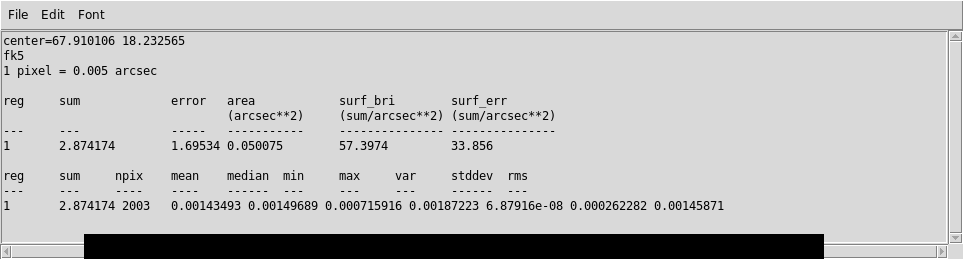

The mean over the annulus is 0.00143493, so we divide the image by that value. The image must also not contain any negative values.

In [12]:
img_data /= 0.00143493
img_data[img_data < 0] = 0.

We can now create the image HDU and add a few things to the header.

In [35]:
img_hdu = fits.ImageHDU(data=img_data, header=wcs.to_header())

In [33]:
img_hdu.header['OBJECT'] = 'HL Tau'

Next, we create a spectrum. To keep things embarrassingly simple, we make it flat in units of Jy. Actually, we want to set the spectrum to $0.1\,\mathrm{Jy\,arcsec^{-2}}$, so we have to scale that value to the pixel area of the image (synphot can't deal with $\mathrm{Jy\,arcsec^{-2}}$...).

In [79]:
wave = np.linspace(2.5, 18.5, 1001) * u.um

pixarea = (wcs.wcs.cdelt[0] * u.Unit(wcs.wcs.cunit[0]))**2
#flux_value = (0.1 * u.Jy / u.arcsec**2 * pixarea).to(u.Jy)
flux_value = 0.01 * u.Jy
flux = np.ones_like(wave.value) * flux_value

In [80]:
spec = SourceSpectrum(Empirical1D, points=wave, lookup_table=flux)

Now we can finally create our `Source` object:

In [81]:
src = sim.Source(spectra=[spec], image_hdu=img_hdu)

## N-band observation of the source

In [39]:
cmd = sim.UserCommands(use_instrument='METIS', set_modes=['img_n'])

In [40]:
metis = sim.OpticalTrain(cmd)

The optical train contains the following effects:

In [41]:
metis.effects

element,name,class,included,z_orders
str20,str32,str22,bool,object
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,True,"[111, 511]"
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,False,"[112, 512]"
ELT,scope_surface_list,SurfaceList,True,"[20, 120, 520]"
ELT,scope_vibration,Vibration,True,"[244, 744]"
ELT,eso_combined_reflection,TERCurve,False,"[10, 110, 510]"
METIS,metis_cfo_surfaces,SurfaceList,True,"[20, 120, 520]"
METIS_IMG_N,metis_img_n_mirror_list,SurfaceList,True,"[20, 120, 520]"
METIS_IMG_N,filter_wheel,FilterWheel,True,"[124, 224, 524]"


We currently need to change a few of these:

In [42]:
metis['armazones_atmo_default_ter_curve'].include = False
metis['armazones_atmo_skycalc_ter_curve'].include = True

In [43]:
metis['scope_vibration'].include = False
metis['detector_linearity'].include = False

In [44]:
metis['scope_surface_list'].include = False
metis['eso_combined_reflection'].include = True

We can now "observe" the source. This command creates the ideal image just in front of the detector.

In [82]:
metis.observe(src, update=True)

Preparing 3 FieldOfViews


Set the exposure time (DIT and NDIT) before reading out the detector:

In [83]:
dit, ndit = 0.0001, 1
metis.cmds['!OBS.dit'] = dit
metis.cmds['!OBS.ndit'] = ndit

In [84]:
outhdul = metis.readout()[0]

Before writing the result to disk, we rescale to one DIT and add a little bit of information to the header.

In [85]:
outhdul[1].data /= ndit
outhdul[0].header['DIT'] = dit
outhdul[0].header['NDIT'] = ndit
outhdul[0].header['EXPTIME'] = dit
outhdul[0].header['INTTIME'] = dit * ndit
outhdul.writeto("hl_tau_metis_n_img.fits", overwrite=True)

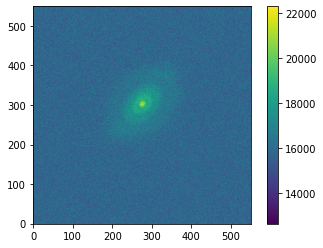

In [86]:
plt.imshow(outhdul[1].data[750:1300,750:1300], origin='lower')
plt.colorbar()